In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

# Here to explore semantic image segmentation using U-net architecture
* To explore - Aireal images captured by drone

# Imports

In [2]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import tensorflow as tf

import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

# EDA and preprocessing
* Lets first check how many classes are there in the image dataset
* Columns - name(class), r,g,b -> pixels true (r,g,b) values for each class

In [3]:
labels = pd.read_csv('../input/semantic-drone-dataset/class_dict_seg.csv')
labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [4]:
labels.name

0       unlabeled
1      paved-area
2            dirt
3           grass
4          gravel
5           water
6           rocks
7            pool
8      vegetation
9            roof
10           wall
11         window
12           door
13          fence
14     fence-pole
15         person
16            dog
17            car
18        bicycle
19           tree
20      bald-tree
21      ar-marker
22       obstacle
23    conflicting
Name: name, dtype: object

# Visualize class colors

In [5]:
def print_label_colors():
    '''
    This method is just to print the label and their colors for reference
    '''
    for index,label in enumerate(labels.name):
        plt.subplot(6,4,index+1)
        (r,g,b)=labels.iloc[index].values[1:]
        img_ = np.array([[[r,g,b],[r,g,b],[r,g,b],[r,g,b]]])
        plt.title(label)
        plt.imshow(img_)
        plt.axis('off')

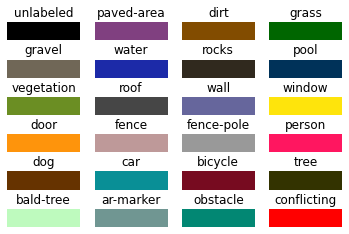

In [6]:
print_label_colors()

## Pre-Process images

In [7]:
inp_dir = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images'
mask_dir = '../input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks'

In [8]:
inp_list = os.listdir(inp_dir)
mask_list=os.listdir(mask_dir)
inp_list.sort()
mask_list.sort()
inp_img_list = [os.path.join(inp_dir,i) for i in inp_list]
mask_list = [os.path.join(mask_dir,i) for i in mask_list]

# Lets visualize few images and thier masked images
* By looking at those masked images, i realized or i guess this type of masked images are shown in movies in which militory use drones to spie on terrists , and implementing such models and visualizing feels cool!! :)

In [9]:
def plt_image_and_mask_by_path(img_list,mask_lst,n=3):
  for i in range(3):
    img1=imageio.imread(img_list[i])
    mask1=imageio.imread(mask_lst[i])
    _,arr = plt.subplots(1,2,figsize=(10,10))
    arr[0].imshow(img1)
    arr[0].axis('off')
    arr[1].imshow(mask1)
    arr[1].axis('off')

In [10]:
def plt_image_and_mask_with_dataset(image_ds,mask_ds):
    _,arr = plt.subplots(1,2,figsize=(10,10))
    arr[0].imshow(tf.keras.preprocessing.image.array_to_img(image_ds))
    arr[0].axis('off')
    arr[1].imshow(tf.keras.preprocessing.image.array_to_img(mask_ds))
    arr[1].axis('off')

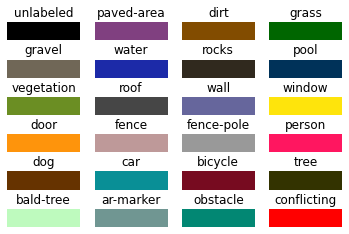

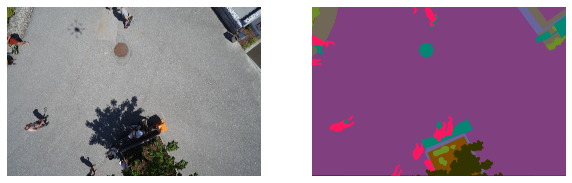

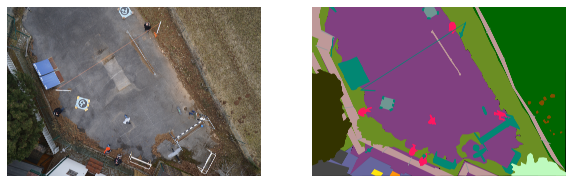

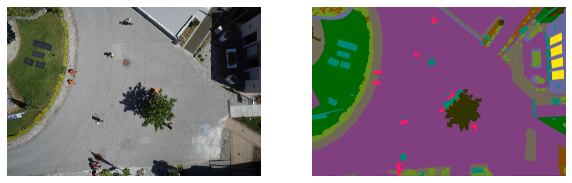

In [11]:
print_label_colors()
plt_image_and_mask_by_path(inp_img_list,mask_list,3)

# Using Tensorflow to pre-process load images into pixel arrays before passing into network

In [12]:
# create images paths as tensors of file paths
image_names  = tf.constant(inp_img_list)
mask_names = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_names,mask_names))
for image,mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg', shape=(), dtype=string)
tf.Tensor(b'../input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/000.png', shape=(), dtype=string)


In [13]:
def process_path(image_,mask_):
    img = tf.io.read_file(image_)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32)
    
    mask = tf.io.read_file(mask_)
    mask = tf.image.decode_png(mask,channels=3)
    ## take max of each pixel vector along channels axis, but keep the dimensions
    ## this is to make training faster(at least compared to 3 channeled mask images)
    ## once we do this , true mask images and new mask images differ by colors of each class
    ## and images are reduced in quality
    mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img,mask

def process(image,mask):
    '''
    reduce the image size
    '''
    inp_image = tf.image.resize(image,(96,128),method='nearest')
    inp_mask = tf.image.resize(mask,(96,128),method='nearest')   
    return inp_image,inp_mask
    
image_ds = dataset.map(process_path)
processed_images_ds = image_ds.map(process)

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


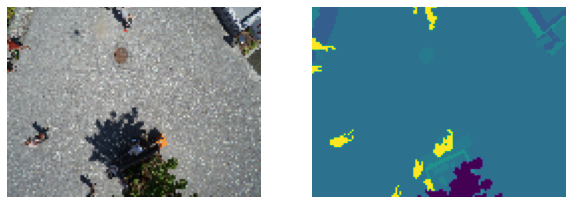

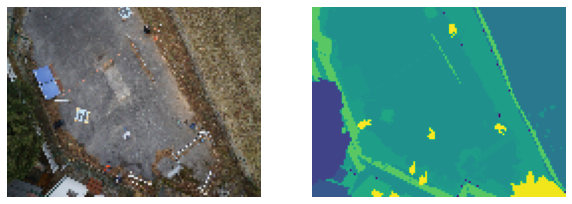

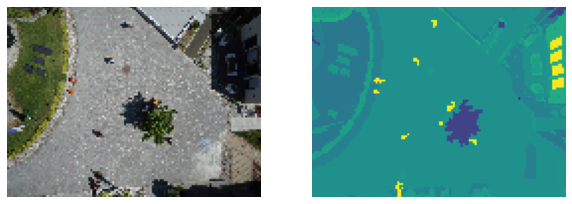

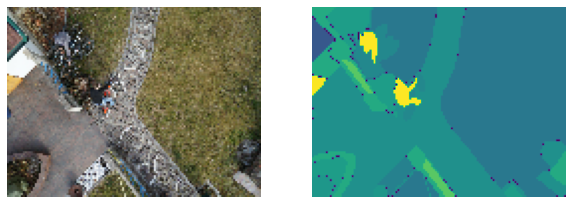

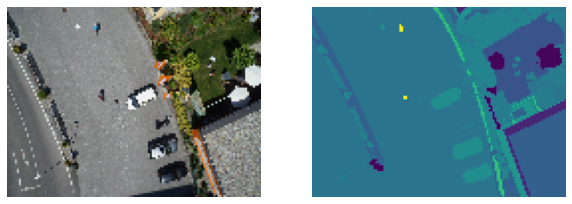

In [14]:
for image,mask in processed_images_ds.take(5):
    plt_image_and_mask_with_dataset(image,mask)

# The U-Net Architecture
## Here i'll be using the coursera graded assignment code that i went through as part of **Convolution Neural Network** course

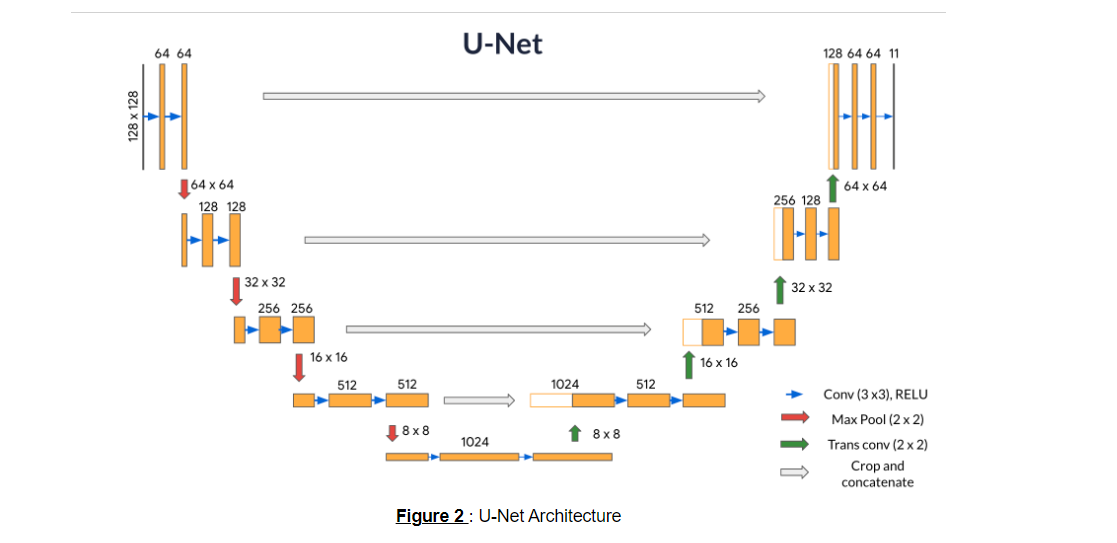

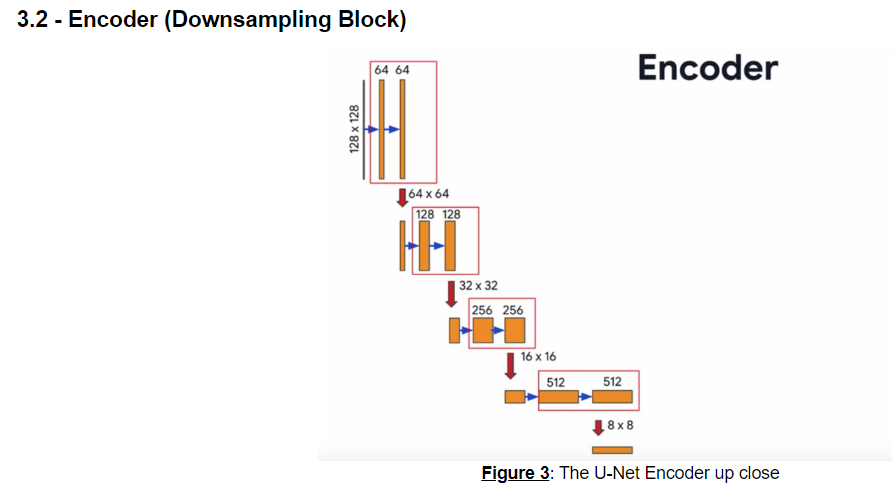

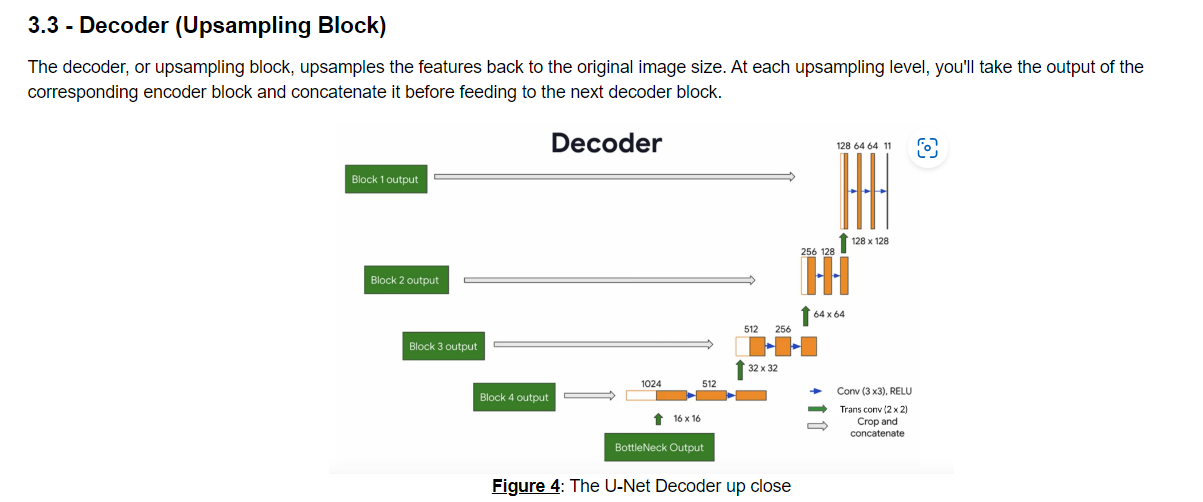

In [15]:
# UNQ_C1
# GRADED FUNCTION: conv_block
def conv_block(inputs=None, n_filters=64, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size=3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [16]:
# UNQ_C2
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=64):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(
                 filters=n_filters,    # number of filters
                 kernel_size=(3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(filters=n_filters,   # Number of filters
                 kernel_size=(3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 kernel_size=(3,3),   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    return conv

In [17]:
# UNQ_C3
# GRADED FUNCTION: unet_model
def unet_model(input_size=(96, 128, 3), n_filters=64, n_classes=256):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [18]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [19]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 128, 64)  1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 64)  36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [20]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
processed_images_ds

<MapDataset shapes: ((96, 128, 3), (96, 128, 1)), types: (tf.float32, tf.uint8)>

In [22]:
EPOCHS = 100
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_images_ds.batch(BATCH_SIZE)
train_dataset = processed_images_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_images_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/100


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

13/13 [==============================] - 263s 358ms/step - loss: 4.3417 - accuracy: 0.2399
Epoch 2/100
13/13 [==============================] - 3s 202ms/step - loss: 2.7911 - accuracy: 0.3728
Epoch 3/100
13/13 [==============================] - 3s 202ms/step - loss: 2.2777 - accuracy: 0.3807
Epoch 4/100
13/13 [==============================] - 3s 202ms/step - loss: 1.9892 - accuracy: 0.4551
Epoch 5/100
13/13 [==============================] - 3s 202ms/step - loss: 1.8070 - accuracy: 0.4926
Epoch 6/100
13/13 [==============================] - 3s 202ms/step - loss: 1.7472 - accuracy: 0.5023
Epoch 7/100
13/13 [==============================] - 3s 202ms/step - loss: 1.6921 - accuracy: 0.5212
Epoch 8/100
13/13 [==============================] - 3s 202ms/step - loss: 1.6720 - accuracy: 0.5229
Epoch 9/100
13/13 [==============================] - 3s 202ms/step - loss: 1.6238 - accuracy: 0.5167
Epoch 10/100
13/13 [==============================] - 3s 204ms/step - loss: 1.5707 - accuracy: 0.5356

In [23]:
unet.save('drone_survellence')

In [24]:
model = tf.keras.models.load_model('drone_survellence')

Text(0.5, 1.0, 'Training loss')

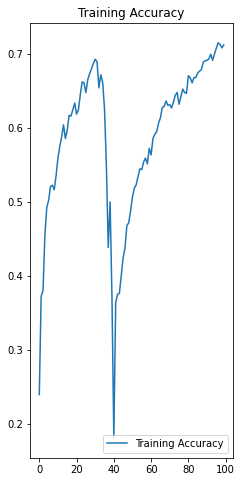

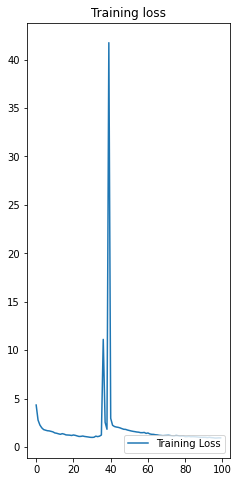

In [25]:
    acc = model_history.history['accuracy']

    loss = model_history.history['loss']

    epochs_range = range(100)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training Accuracy')
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.legend(loc='lower right')
    plt.title('Training loss')

In [26]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [27]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [28]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])

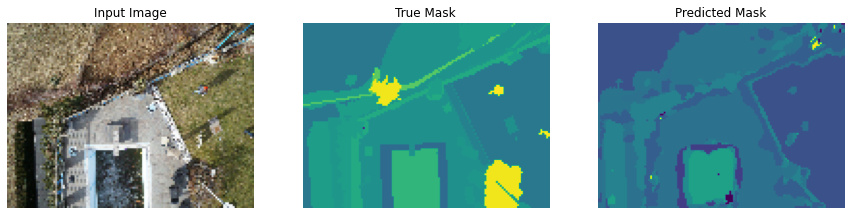

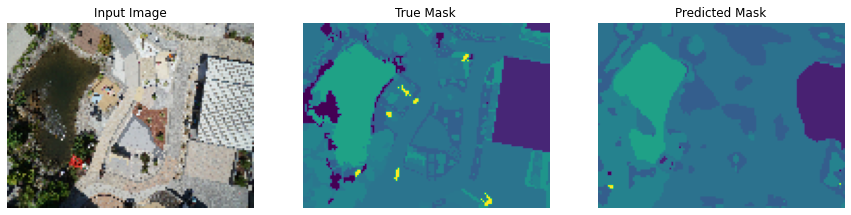

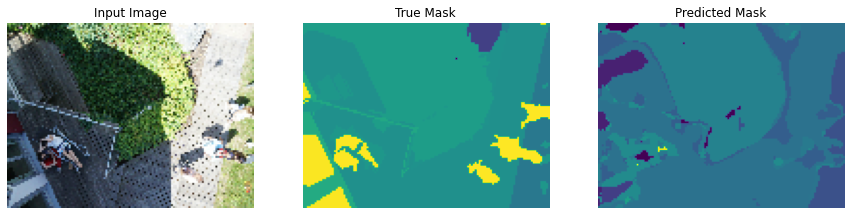

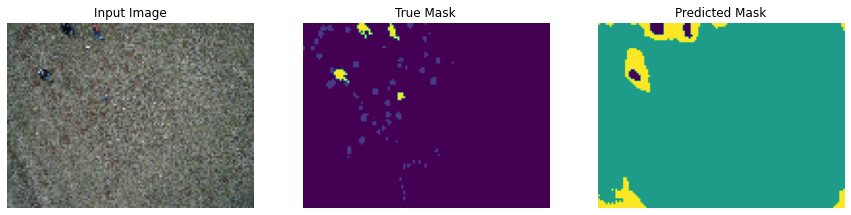

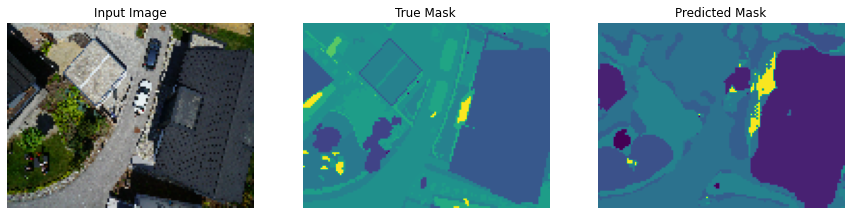

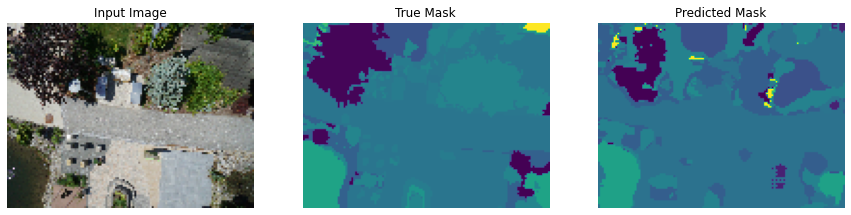

In [29]:
show_predictions(train_dataset, 6)

# NEEDS Parameter tuning, bit of underfitting problem
## TODO
1. Implement with original U-Net archictecture filters and other params
2. Split dataset into train ,validation & test data sets to tune the performance